<a href="https://colab.research.google.com/github/raynardj/python4ml/blob/master/experiments/Adversarial_Attack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Adversarial Attack
### How to cripple other's neural networks

In [0]:
import torch
from torch import nn
from torchvision.models.resnet import resnet50

### Install Tool  Package

In [2]:
!pip install git+https://github.com/raynardj/forge

  Cloning https://github.com/raynardj/forge to /tmp/pip-req-build-w69oaiip
  Running command git clone -q https://github.com/raynardj/forge /tmp/pip-req-build-w69oaiip
     |████████████████████████████████| 81kB 8.3MB/s 
     |████████████████████████████████| 1.5MB 30.0MB/s 
     |████████████████████████████████| 40kB 19.4MB/s 
     |████████████████████████████████| 51kB 23.9MB/s 
     |████████████████████████████████| 102kB 37.2MB/s 
     |████████████████████████████████| 133kB 54.3MB/s 
     |████████████████████████████████| 174kB 57.1MB/s 
  Stored in directory: /tmp/pip-ephem-wheel-cache-n49ubiri/wheels/79/da/27/142ebff4ec83438e5bca1075d78c22909c306a7f2478eaaffe
  Stored in directory: /root/.cache/pip/wheels/1e/b0/61/e8a16b4c2f4eac24f0e409e6c296032dbd23f71cf93dfde539
  Stored in directory: /root/.cache/pip/wheels/2e/56/0c/ae3cc1279a4d1c5b7cec98634973266e3b4c06d026c2fc35cf
  Stored in directory: /root/.cache/pip/wheels/94/98/8f/b357415afe27adcdf071306f3f981e61a0498b7101707471

### Pretrained Model
Download the pretrianed ResNet50,  on imagenet classification

In [3]:
m = resnet50(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:03<00:00, 29414557.14it/s]


### Mount Google Drive

In [4]:
# load the google drive
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import os
os.chdir('/content/gdrive/My Drive/Colab Notebooks/adversarial_attack')
# !du -sh test_images/val2017/

The 1000 indices vs 1000 category descriptions

In [20]:
from imagenet_cates import mapping
mapping[1],mapping[100],mapping[200],mapping[300]

('goldfish, Carassius auratus',
 'black swan, Cygnus atratus',
 'Tibetan terrier, chrysanthemum dog',
 'tiger beetle')

Image transformation pipeline:

In [0]:
from torchvision import transforms as tr
# image transformation
trans = tr.Compose([
    tr.RandomAffine((-10,10)), # Ramdomly rotate -10 degrees to 10 degrees
    tr.Resize((224,224),),
    tr.ToTensor(),
])

trans_norm = tr.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

Create an image dataset from image folder

In [0]:
from torchvision.datasets import ImageFolder
ds = ImageFolder(root = "test_images/",transform=trans)

In [11]:
print(len(ds))

818


In [0]:
from forgebox.ftorch.prepro import test_DS
from forgebox.ftorch.train import Trainer

testx,testy = test_DS(ds)()

### Attack Network

In [0]:
import torch
from torch import nn

def cvblock(ks,in_,out_,act=nn.ReLU()):
    layers = [
        nn.Conv2d(in_,out_,kernel_size=ks, padding=ks//2,),
        nn.BatchNorm2d(out_,),
    ]
    if act: layers.append(act)
    return nn.Sequential(*layers)

# Normalize Module

# Normalize the image, the mean and std are based on imagenet, 
# The dataset our pretrained resnet 50 was trained on
# Why not using the normalize in torchvision.transforms? because we have to normalize images in batch in this case

class Normalize(nn.Module):
    def __init__(self,mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
        super().__init__()
        self.mean_ = torch.FloatTensor(mean).unsqueeze(0).unsqueeze(-1).unsqueeze(-1)
        self.std_ = torch.Tensor(std).unsqueeze(0).unsqueeze(-1).unsqueeze(-1)
        
    def forward(self,x):
        return (x-\
                self.mean_.repeat([x.size(0),1,x.size(2),x.size(3)]))\
                /self.std_.repeat([x.size(0),1,x.size(2),x.size(3)])
    
# Attack Network

# The attack network is an image generator based on the original image
# It will generate an image to interfere the original image
# even if the interference is indifferent to human eyes
class attack(nn.Module):
    def __init__(self, width = 128):
        """
        Create interference using the original image
        """
        super().__init__()
        netlist = [cvblock(3,3,width)]+list(cvblock(3,width,width) for i in range(5))+[cvblock(3,width,3, act= nn.Tanh())]
        self.net = nn.Sequential(*netlist)
        
    def forward(self,x):
        return self.net(x)/30

In [0]:
# CUDA, a True/False value to see if we are using GPU cuda
CUDA = torch.cuda.is_available()
atk = attack()
norm = Normalize()

# put models on GPU, if any
if CUDA: atk = atk.cuda()
if CUDA: norm.mean_ = norm.mean_.cuda();norm.std_ = norm.std_.cuda()
if CUDA: m = m.cuda()
# set the ResNet (victim AI) to eval model (Not change/updated through training)
m.eval()

# Define loss function: cross entropy, for this is a classification situation
lossfunc = nn.CrossEntropyLoss()

# The optimizer will only update the "attack network"
opt = torch.optim.Adam(atk.parameters())

In [0]:
# atk.load_state_dict(torch.load("attack.npy"))

In [0]:
t = Trainer(ds,batch_size = 16,print_on = 3)

@t.step_train
def action(batch):
    if batch.i ==0 :
        atk.train()
    # get the image tensor, label from iterator
    x,_ = batch.data
    if CUDA:x = x.cuda()
        
    # The target y is to make resnet think, this image belongs to category 100: black swan
    y = (torch.ones(x.size(0))*100).long() 
    if CUDA: y=y.cuda()
        
    opt.zero_grad()
        
    x = x+atk(x) # decorate the original image
    x = torch.clamp(x,0.,1.) # make sure it contains healthy pixel value range: 0. to 1.
    x = norm(x)
    # let the classification modal has its guess
    y_ = m(x) 
    loss = lossfunc(y_,y) 
    
    loss.backward()
    opt.step()
    
    # how good we can fool resnet now?
    acc = (torch.max(y_,dim=-1,keepdim=True)[1]==y).float().mean() 
    return {"acc":acc.item(),"loss":loss.item()}

In [0]:
t.train(30)

In [0]:
torch.save(atk.state_dict(), "attack.npy")

In [0]:
torch.cuda.empty_cache()

### Testing the effect visually

In [0]:
from PIL import Image

In [0]:

image_tensor = trans(Image.open(ds.imgs[20][0]))

In [0]:
toimage = tr.ToPILImage()

def interfere(image_tensor):
    if CUDA:
        image_tensor = image_tensor.cuda()
    noise = atk(image_tensor.unsqueeze(0))
    if CUDA:
        noise = noise.cpu()
        image_tensor = image_tensor.cpu()
    return noise[0], noise[0]+image_tensor

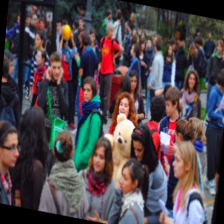

In [35]:
toimage(image_tensor)

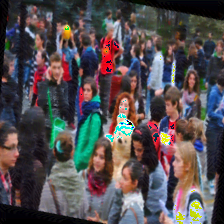

In [36]:
noise, image_interfered  = interfere(image_tensor)
toimage(image_interfered)

In [39]:
noise.max(), noise.min()

(tensor(0.0500, grad_fn=<MaxBackward1>),
 tensor(2.0174e-11, grad_fn=<MinBackward1>))